In [1]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
import torch
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
model_dir = "../bin/"
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)

In [19]:
tokenizer = LongformerTokenizer.from_pretrained(
    "allenai/longformer-base-4096", max_length=2048
)

In [5]:
baa_model = LongformerForSequenceClassification.from_pretrained(
    "../bin/baa_model", num_labels=1
).to(device)
control_model = LongformerForSequenceClassification.from_pretrained(
    "../bin/control_model", num_labels=1
).to(device)
hl_model = LongformerForSequenceClassification.from_pretrained(
    "../bin/hl_model", num_labels=1
).to(device)
w_model = LongformerForSequenceClassification.from_pretrained(
    "../bin/w_model", num_labels=1
).to(device)

In [10]:
df = pd.read_csv("../data/test_df.csv", index_col=0)

In [34]:
def predict_score(model, input_text):
    tokenized_text = tokenizer(input_text, truncation=True, return_tensors="pt").to(
        device
    )
    outputs = model(tokenized_text["input_ids"])
    return outputs.logits[0][0].item()

In [40]:
df["control_pred"] = df["full_text"].apply(lambda x: predict_score(control_model, x))

In [42]:
df["baa_pred"] = df["full_text"].apply(lambda x: predict_score(baa_model, x))

In [ ]:
df["hl_pred"] = df["full_text"].apply(lambda x: predict_score(hl_model, x))

In [ ]:
df["w_pred"] = df["full_text"].apply(lambda x: predict_score(w_model, x))

In [51]:
df_long = (
    pd.melt(
        df,
        id_vars=[
            "essay_id",
            "holistic_score_1",
            "holistic_score_2",
            "holistic_score_adjudicated",
            "full_text",
            "source",
            "source_text",
            "prompt_name",
            "task",
            "assignment",
            "gender",
            "grade",
            "ell",
            "race_ethnicity",
            "economically_disadvantaged",
            "student_disability_status",
        ],
        value_vars=["control_pred", "baa_pred", "hl_pred", "w_pred"],
    )
    .sort_values(by="essay_id")
    .rename(columns={"variable": "model", "value": "prediction"})
)

In [77]:
df_long["pred_error"] = df_long["prediction"] - df_long["holistic_score_adjudicated"]
df_long["squared_error"] = df_long["pred_error"].apply(lambda x: x**2)

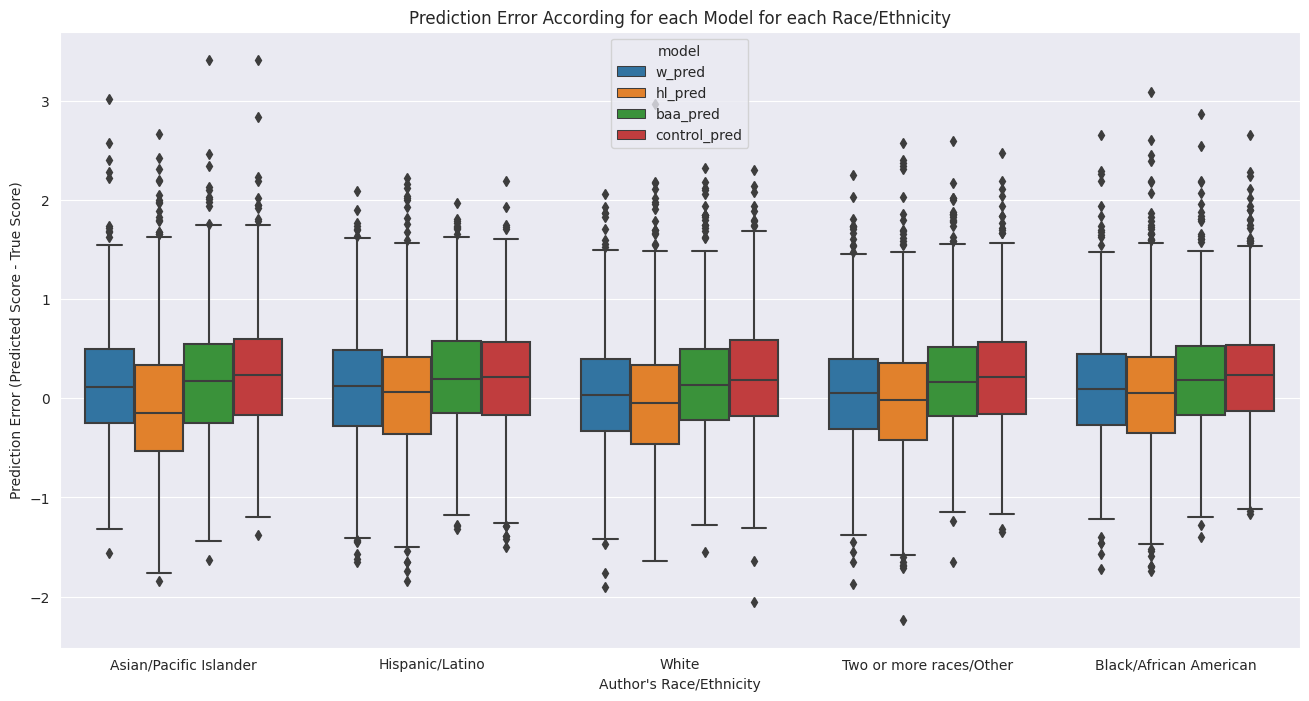

In [79]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")
chart = plt.figure(figsize=(16, 8))
sns.boxplot(df_long, x="race_ethnicity", y="pred_error", hue="model")
plt.title("Prediction Error According for each Model for each Race/Ethnicity")
plt.xlabel("Author's Race/Ethnicity")
plt.ylabel("Prediction Error (Predicted Score - True Score)")
plt.show()

In [58]:
df_long.columns

Index(['essay_id', 'holistic_score_1', 'holistic_score_2',
       'holistic_score_adjudicated', 'full_text', 'source', 'source_text',
       'prompt_name', 'task', 'assignment', 'gender', 'grade', 'ell',
       'race_ethnicity', 'economically_disadvantaged',
       'student_disability_status', 'model', 'prediction', 'pred_error'],
      dtype='object')

In [86]:
for i in df_long["model"].drop_duplicates():
    print("MSE for " + i)
    temp_df = df_long[df_long["model"] == i]
    for j in df_long["race_ethnicity"].drop_duplicates():
        mse = temp_df[temp_df["race_ethnicity"] == j]["squared_error"].mean()
        print(j + ",", mse)
    print("Total,", temp_df["squared_error"].mean())

MSE for w_pred
Asian/Pacific Islander, 0.3558964579803014
Hispanic/Latino, 0.35473956905565196
White, 0.3345058168952098
Two or more races/Other, 0.3229252817759957
Black/African American, 0.3362247151035828
Total, 0.3408583681621484
MSE for hl_pred
Asian/Pacific Islander, 0.5117247264329576
Hispanic/Latino, 0.3915453235487148
White, 0.4057715086004745
Two or more races/Other, 0.39410596313558865
Black/African American, 0.41033412163223526
Total, 0.42269632866999424
MSE for baa_pred
Asian/Pacific Islander, 0.3643029633049851
Hispanic/Latino, 0.3475891843169386
White, 0.3407398489782257
Two or more races/Other, 0.34113313049076716
Black/African American, 0.3340780222124891
Total, 0.3455686298606811
MSE for control_pred
Asian/Pacific Islander, 0.3647577142230606
Hispanic/Latino, 0.3314577945051179
White, 0.3551267984863448
Two or more races/Other, 0.3522163787339124
Black/African American, 0.3402604870279366
Total, 0.3487638345952745


In [87]:
df_long.to_csv("../data/persuade-predictions-long.csv")

In [2]:
df_long = pd.read_csv("../data/persuade-predictions-long.csv")

In [22]:
plot_dict = {}
for i in df_long.model.drop_duplicates():
    plot_dict[i] = df_long[df_long["model"] == i][
        ["holistic_score_adjudicated", "prediction"]
    ].corr()

plot_dict

{'w_pred':                             holistic_score_adjudicated  prediction
 holistic_score_adjudicated                    1.000000    0.879759
 prediction                                    0.879759    1.000000,
 'hl_pred':                             holistic_score_adjudicated  prediction
 holistic_score_adjudicated                    1.000000    0.852744
 prediction                                    0.852744    1.000000,
 'baa_pred':                             holistic_score_adjudicated  prediction
 holistic_score_adjudicated                    1.000000    0.888615
 prediction                                    0.888615    1.000000,
 'control_pred':                             holistic_score_adjudicated  prediction
 holistic_score_adjudicated                    1.000000    0.892255
 prediction                                    0.892255    1.000000}

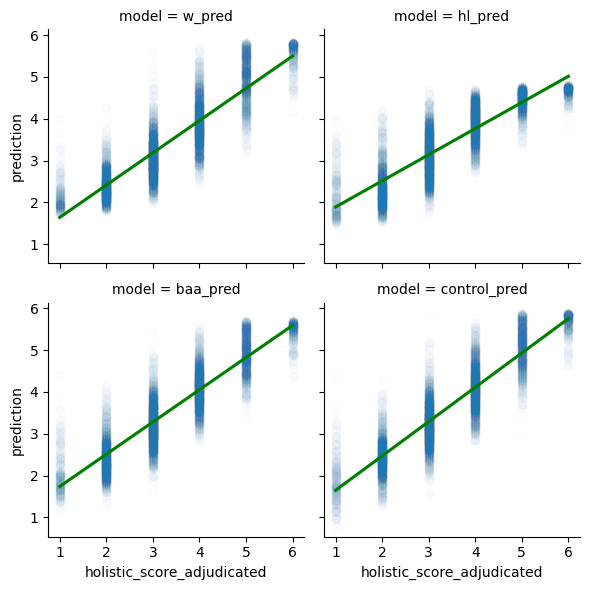

In [27]:
# define grid
g = sns.FacetGrid(data=df_long, col="model", col_wrap=2)

# add plots to grid
g.map(
    sns.regplot,
    "holistic_score_adjudicated",
    "prediction",
    scatter_kws={"alpha": 0.01},
    line_kws={"color": "green"},
)

In [12]:
plot_dict

{'w_pred': <seaborn.axisgrid.FacetGrid at 0x7fcbb617f5b0>,
 'hl_pred': <seaborn.axisgrid.FacetGrid at 0x7fc955715720>,
 'baa_pred': <seaborn.axisgrid.FacetGrid at 0x7fc95579dbd0>,
 'control_pred': <seaborn.axisgrid.FacetGrid at 0x7fc9557e3a30>}